# 🧠 Stroke Prediction Project
Cleaned and organized notebook with data processing, EDA, modeling, and evaluation.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean data
data = pd.read_csv("/Users/arezkibali/Downloads/stroke_data.csv")
data.drop(columns=['id'], inplace=True)
data = data[data['gender'] != 'Other']
data['bmi'] = data['bmi'].fillna(data['bmi'].median())




## 📊 Exploratory Data Analysis (EDA)

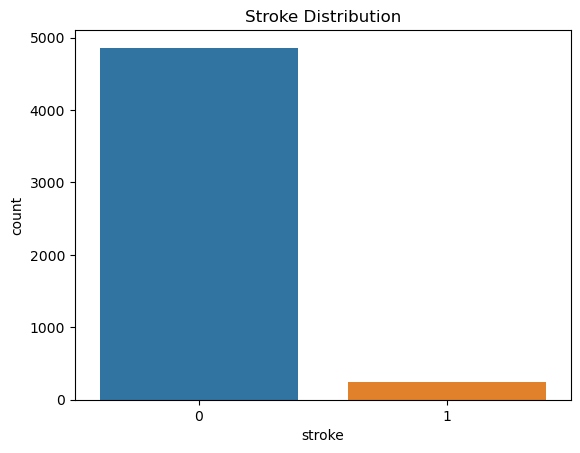

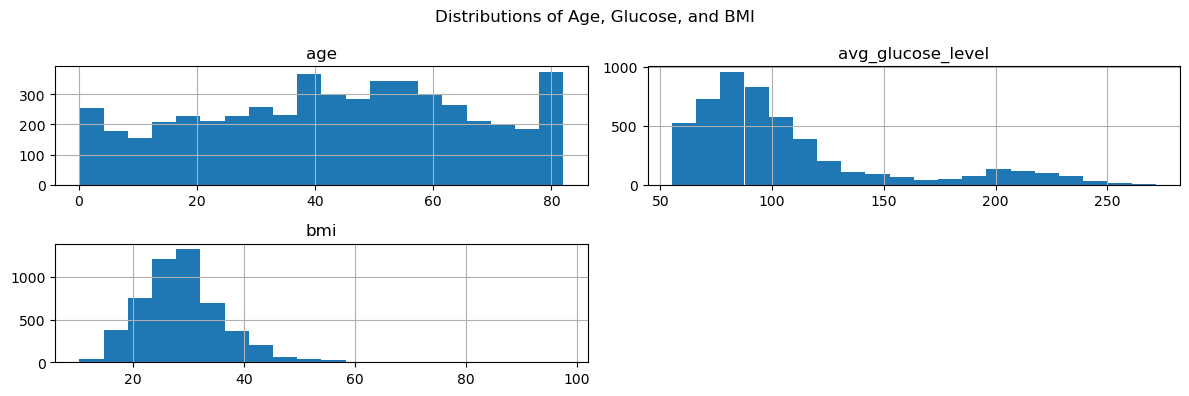

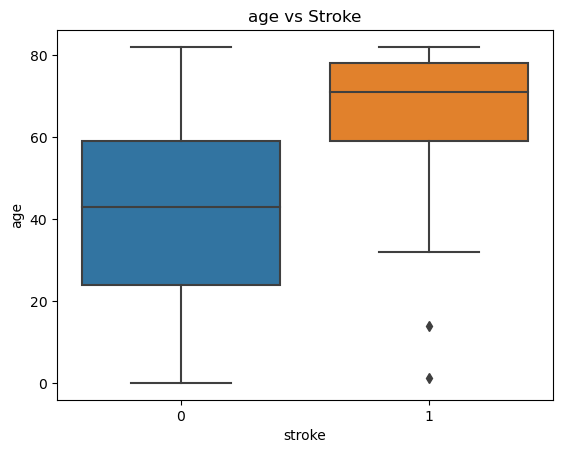

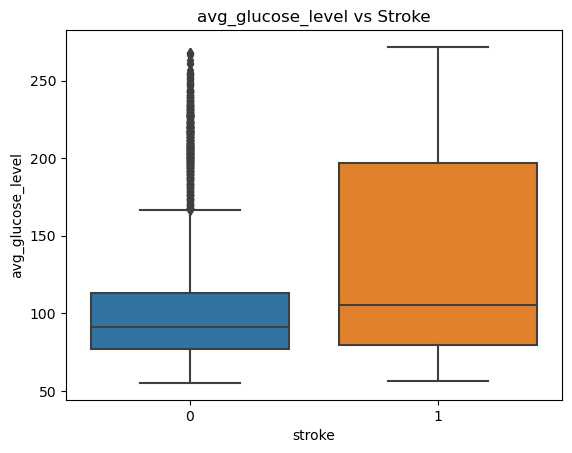

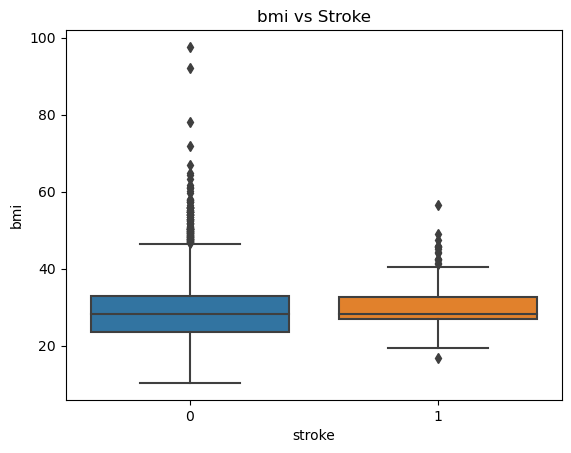

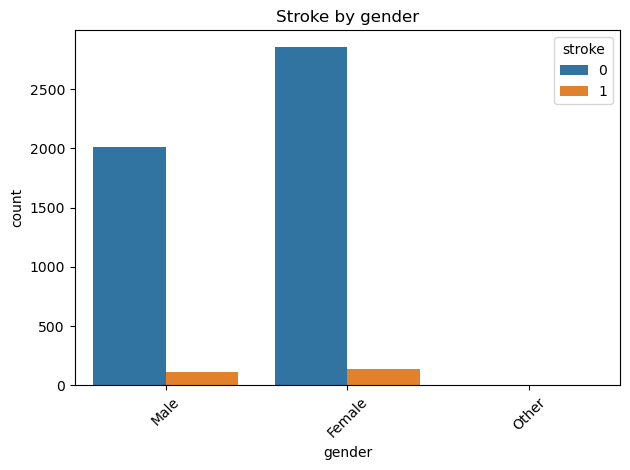

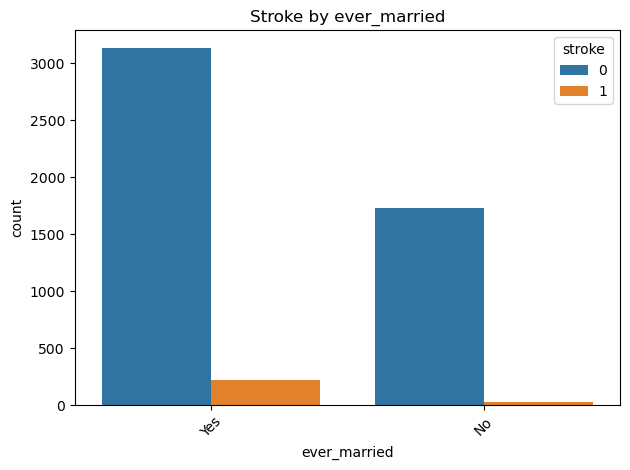

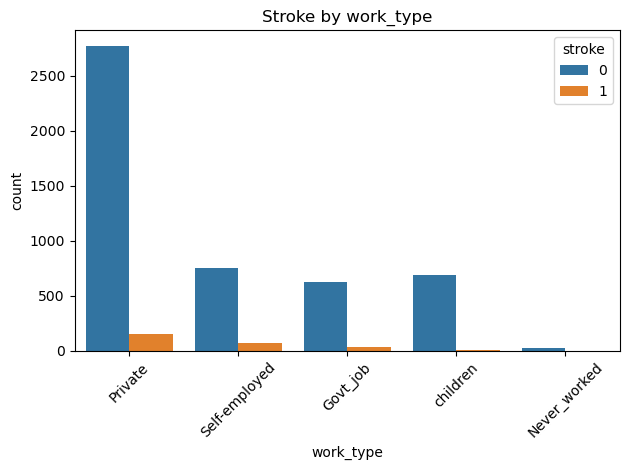

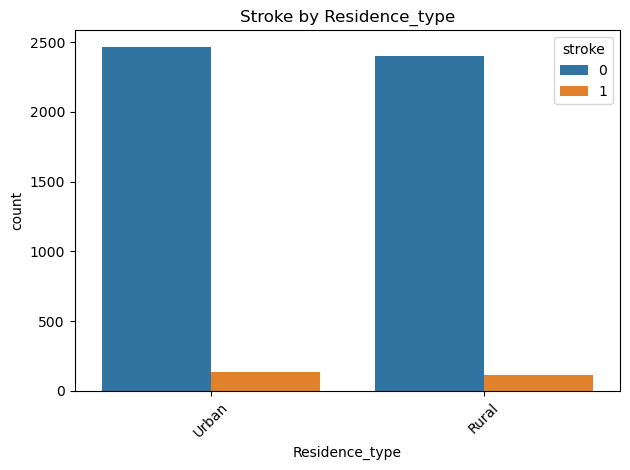

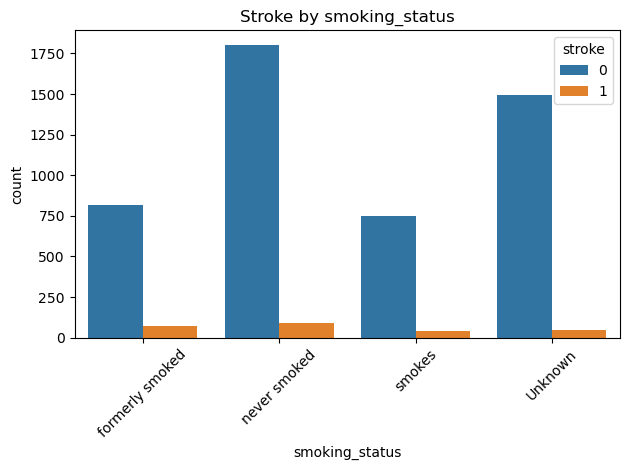

In [100]:
# Class balance
sns.countplot(data=data, x='stroke')
plt.title('Stroke Distribution')
plt.show()

# Histograms of numerical variables
num_cols = ['age', 'avg_glucose_level', 'bmi']
data[num_cols].hist(bins=20, figsize=(12, 4))
plt.suptitle("Distributions of Age, Glucose, and BMI")
plt.tight_layout()
plt.show()

# Boxplots by stroke outcome
for col in num_cols:
    sns.boxplot(data=data, x='stroke', y=col)
    plt.title(f"{col} vs Stroke")
    plt.show()

# Categorical count plots
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in cat_cols:
    sns.countplot(data=pd.read_csv("/Users/arezkibali/Downloads/stroke_data.csv"), x=col, hue='stroke')
    plt.title(f"Stroke by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [86]:
# Feature engineering
data['age_glucose'] = data['age'] * data['avg_glucose_level']
data['age_bmi'] = data['age'] * data['bmi']
data['risk_score'] = data['hypertension'] + data['heart_disease']
data['bmi_glucose'] = data['bmi'] * data['avg_glucose_level']

# One-hot encoding
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Split features and target
X = data.drop(columns=['stroke'])
y = data['stroke']

# Select best features
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)


# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [87]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

def optimize_threshold(y_true, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_idx = f1_scores.argmax()
    return thresholds[best_idx], f1_scores[best_idx]

def evaluate_model(name, y_true, y_probs, threshold):
    y_pred = (y_probs >= threshold).astype(int)
    print(f"\nModel: {name}")
    print(f"Optimal Threshold: {threshold:.2f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Stroke', 'Stroke']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


In [88]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)
y_probs_lr = lr_model.predict_proba(X_test)[:, 1]

threshold_lr, f1_lr = optimize_threshold(y_test, y_probs_lr)
evaluate_model("Logistic Regression", y_test, y_probs_lr, threshold_lr)



Model: Logistic Regression
Optimal Threshold: 0.86
Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.96      0.96       972
      Stroke       0.33      0.40      0.36        50

    accuracy                           0.93      1022
   macro avg       0.65      0.68      0.66      1022
weighted avg       0.94      0.93      0.93      1022

Confusion Matrix:
[[932  40]
 [ 30  20]]


In [89]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

threshold_rf, f1_rf = optimize_threshold(y_test, y_probs_rf)
evaluate_model("Random Forest", y_test, y_probs_rf, threshold_rf)



Model: Random Forest
Optimal Threshold: 0.54
Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.95      0.96       972
      Stroke       0.27      0.36      0.31        50

    accuracy                           0.92      1022
   macro avg       0.62      0.65      0.63      1022
weighted avg       0.93      0.92      0.93      1022

Confusion Matrix:
[[923  49]
 [ 32  18]]


In [90]:
from xgboost import XGBClassifier

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

threshold_xgb, f1_xgb = optimize_threshold(y_test, y_probs_xgb)
evaluate_model("XGBoost", y_test, y_probs_xgb, threshold_xgb)



Model: XGBoost
Optimal Threshold: 0.20
Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.92      0.94       972
      Stroke       0.19      0.36      0.25        50

    accuracy                           0.89      1022
   macro avg       0.58      0.64      0.60      1022
weighted avg       0.93      0.89      0.91      1022

Confusion Matrix:
[[896  76]
 [ 32  18]]


In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build neural network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
nn_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

# Predict and evaluate
y_probs_nn = nn_model.predict(X_test).flatten()
threshold_nn, f1_nn = optimize_threshold(y_test, y_probs_nn)
evaluate_model("Neural Network", y_test, y_probs_nn, threshold_nn)


Epoch 1/100


/Users/arezkibali/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8166 - loss: 0.4597 - val_accuracy: 0.9425 - val_loss: 0.1987
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9479 - loss: 0.1961 - val_accuracy: 0.9425 - val_loss: 0.1916
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.9468 - loss: 0.1792 - val_accuracy: 0.9425 - val_loss: 0.1885
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.9556 - loss: 0.1553 - val_accuracy: 0.9425 - val_loss: 0.1877
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.9529 - loss: 0.1688 - val_accuracy: 0.9425 - val_loss: 0.1863
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.9548 - loss: 0.1500 - val_accuracy: 0.9425 - val_loss: 0.1868
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.9538 - loss: 0.1570 - val_accuracy: 0.9425 - val_loss: 0.1861
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.9522 - loss: 0.1573 - val_ac

## 🔁 Comparison: Models With vs Without Feature Engineering

In [93]:
# Load original data again (without engineered features)
raw_data = pd.read_csv("/Users/arezkibali/Downloads/stroke_data.csv")
raw_data.drop(columns=['id'], inplace=True)
raw_data = raw_data[raw_data['gender'] != 'Other']
raw_data['bmi'] = raw_data['bmi'].fillna(raw_data['bmi'].median())

# One-hot encode original categorical features only
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
raw_data = pd.get_dummies(raw_data, columns=categorical_cols, drop_first=True)

# Split X and y
X_raw = raw_data.drop(columns=['stroke'])
y_raw = raw_data['stroke']

# Train/test split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42)

# Scale
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

# Logistic Regression on raw features
lr_raw = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_raw.fit(X_train_raw, y_train_raw)
y_probs_lr_raw = lr_raw.predict_proba(X_test_raw)[:, 1]
threshold_lr_raw, f1_lr_raw = optimize_threshold(y_test_raw, y_probs_lr_raw)
evaluate_model("Logistic Regression (Raw)", y_test_raw, y_probs_lr_raw, threshold_lr_raw)

# XGBoost on raw features
xgb_raw = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=y_train_raw.value_counts()[0] / y_train_raw.value_counts()[1])
xgb_raw.fit(X_train_raw, y_train_raw)
y_probs_xgb_raw = xgb_raw.predict_proba(X_test_raw)[:, 1]
threshold_xgb_raw, f1_xgb_raw = optimize_threshold(y_test_raw, y_probs_xgb_raw)
evaluate_model("XGBoost (Raw)", y_test_raw, y_probs_xgb_raw, threshold_xgb_raw)



Model: Logistic Regression (Raw)
Optimal Threshold: 0.86
Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.96      0.96       972
      Stroke       0.32      0.36      0.34        50

    accuracy                           0.93      1022
   macro avg       0.64      0.66      0.65      1022
weighted avg       0.94      0.93      0.93      1022

Confusion Matrix:
[[934  38]
 [ 32  18]]

Model: XGBoost (Raw)
Optimal Threshold: 0.06
Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.85      0.91       972
      Stroke       0.15      0.50      0.23        50

    accuracy                           0.83      1022
   macro avg       0.56      0.68      0.57      1022
weighted avg       0.93      0.83      0.87      1022

Confusion Matrix:
[[828 144]
 [ 25  25]]


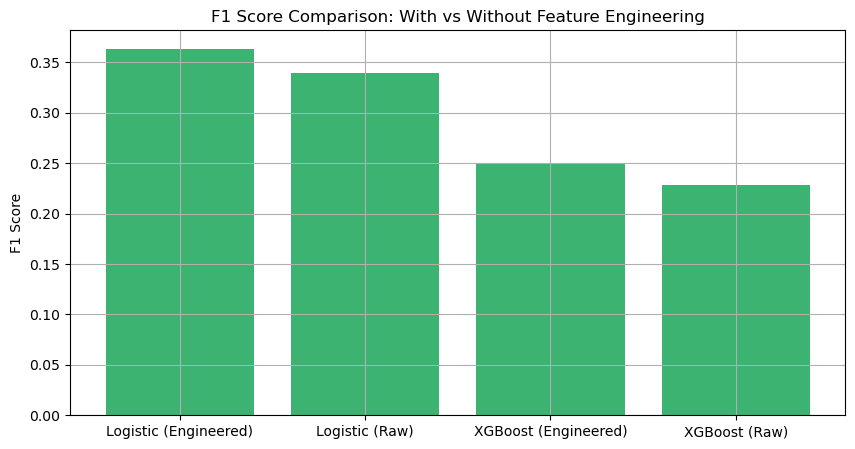

Logistic (Engineered): 0.364
Logistic (Raw): 0.340
XGBoost (Engineered): 0.250
XGBoost (Raw): 0.228


In [94]:
# Compare final F1-scores
f1_compare = {
    "Logistic (Engineered)": f1_lr,
    "Logistic (Raw)": f1_lr_raw,
    "XGBoost (Engineered)": f1_xgb,
    "XGBoost (Raw)": f1_xgb_raw
}

plt.figure(figsize=(10, 5))
plt.bar(f1_compare.keys(), f1_compare.values(), color='mediumseagreen')
plt.title("F1 Score Comparison: With vs Without Feature Engineering")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

# Print sorted comparison
for model, score in sorted(f1_compare.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.3f}")


## ✅ SHAP Analysis for XGBoost (Recommended with TreeExplainer)

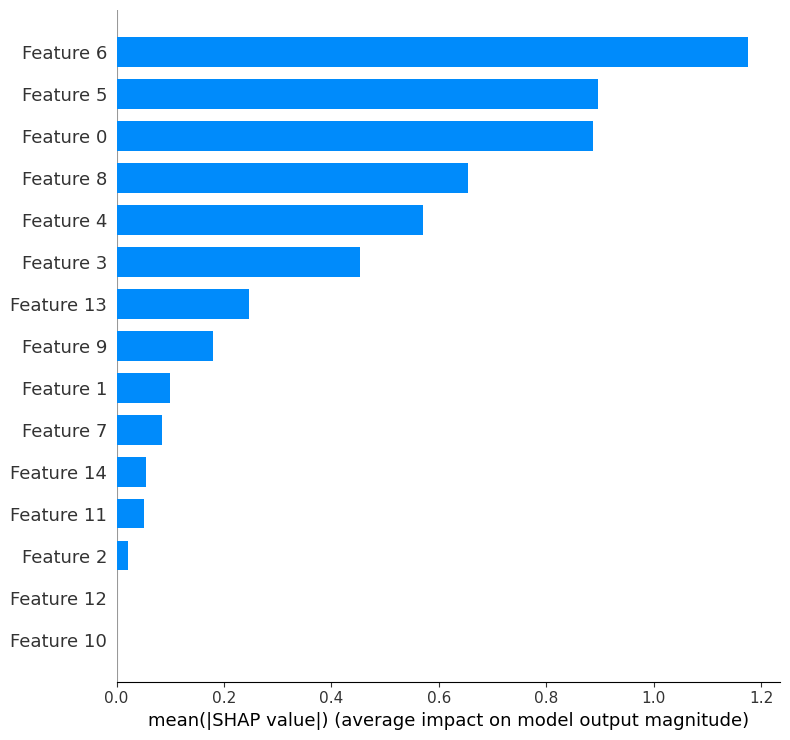

In [95]:
import shap

explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type='bar')


## 🔍 SHAP Analysis for Logistic Regression (Experimental with scikit-learn ≥1.3)

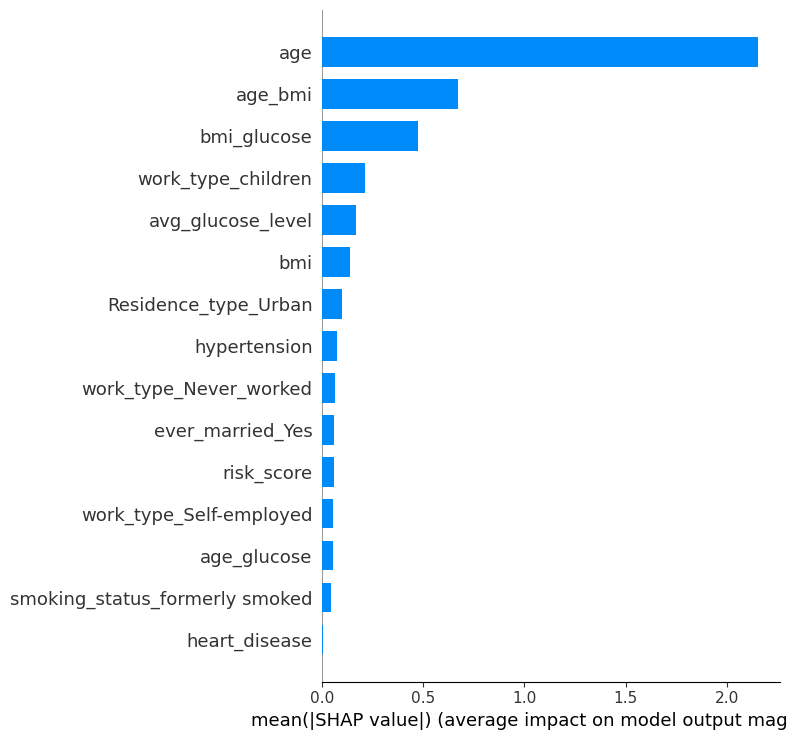

In [96]:
import shap

# Attempt SHAP with Explainer on Logistic Regression
try:
    explainer_lr = shap.Explainer(lr_model, X_train, feature_names=selector.get_feature_names_out())
    shap_values_lr = explainer_lr(X_test)
    shap.summary_plot(shap_values_lr, X_test, plot_type='bar')
except Exception as e:
    print("SHAP for Logistic Regression failed with error:", e)


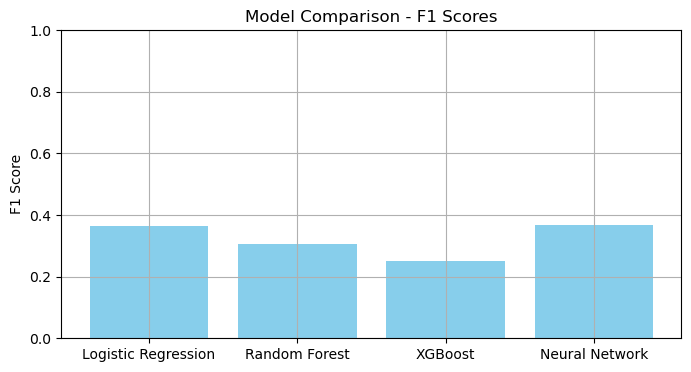

Sorted F1 Scores:
Neural Network: 0.367
Logistic Regression: 0.364
Random Forest: 0.308
XGBoost: 0.250


In [97]:
# Collect and display F1 scores
f1_scores = {
    "Logistic Regression": f1_lr,
    "Random Forest": f1_rf,
    "XGBoost": f1_xgb,
    "Neural Network": f1_nn
}

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.ylabel("F1 Score")
plt.title("Model Comparison - F1 Scores")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Print sorted F1 scores
sorted_f1 = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
print("Sorted F1 Scores:")
for model, score in sorted_f1.items():
    print(f"{model}: {score:.3f}")
